In [58]:
import pandas as pd
from glob import glob
from tqdm import tqdm
import requests
import json
import matplotlib.pyplot as plt
from model_training_process import *
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices("GPU")
print(f"tf.config.list_physical_devices('GPU'): {tf.config.list_physical_devices('GPU')}")

tf.config.list_physical_devices('GPU'): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [41]:
class_df = pd.read_csv(filepath_or_buffer="..\\tables\\corrected_class_df_pinyin_label_table.csv")
class_df

,bopomofo,pinyin,hu_yin,she2_yin,hu_yin_label,she2_yin_label,class_label
0,ㄓ,zhi,純聲符,翹舌音,0,5,0
1,ㄔ,chi,純聲符,翹舌音,0,5,0
2,ㄕ,shi,純聲符,翹舌音,0,5,0
3,ㄖ,ri,純聲符,翹舌音,0,5,0
4,ㄗ,zi,純聲符,平舌音,0,6,1
...,...,...,...,...,...,...,...
402,ㄒㄩㄣ,xun,撮口呼,舌面音,4,4,20
403,ㄩㄥ,yong,撮口呼,純韻符,4,0,18
404,ㄐㄩㄥ,jiong,撮口呼,舌面音,4,4,20
405,ㄑㄩㄥ,qiong,撮口呼,舌面音,4,4,20


In [42]:
npy_file_path = glob("..\\..\\data\\*EduVer\\*.npy", recursive=True)
print(f"len(npy_file_path) = {len(npy_file_path)}")

len(npy_file_path) = 67173


In [43]:
npy_file_path_selected = list()
for npy_file in npy_file_path:
    pinyin = npy_file.split("_")[1]
    pinyin_non_accent = pinyin[:-1] if pinyin[-1].isdigit() else pinyin
    if pinyin_non_accent in list(class_df["pinyin"]):
        npy_file_path_selected.append(npy_file)
print(f"len(npy_file_path_selected) = {len(npy_file_path_selected)}")

len(npy_file_path_selected) = 66852


In [44]:
data_class_label = list()
for npy_file in tqdm(npy_file_path_selected):
    pinyin = npy_file.split("_")[1]
    pinyin_non_accent = pinyin[:-1] if pinyin[-1].isdigit() else pinyin
    class_label = class_df.loc[class_df["pinyin"] == pinyin_non_accent, "class_label"].iloc[0]
    data_class_label.append(class_label)
data_class_label = np.array(data_class_label)
print(f"len(data_class_label) = {len(data_class_label)}")

100%|██████████| 66852/66852 [00:06<00:00, 10867.31it/s]

len(data_class_label) = 66852


In [45]:
mfcc_matrix_list = list()
for npy_file in tqdm(npy_file_path_selected):
    mfcc_matrix = np.load(npy_file)
    mfcc_matrix_list.append(mfcc_matrix)
mfcc_matrix_list = np.array(mfcc_matrix_list)
print(f"len(mfcc_matrix_list) = {len(mfcc_matrix_list)}")

100%|██████████| 66852/66852 [00:06<00:00, 10586.91it/s]

len(mfcc_matrix_list) = 66852


In [60]:
best_params = json.load(open(f"..\\..\\grid_search\\method1_with_fake_data\\best_params.json", "r"))

learning_rate = best_params["learning_rate"]
num_filters = best_params["num_filters"]
dense_units = best_params["dense_unit"]
batch_size = best_params["batch_size"]
epochs = best_params["epochs"]

channel = 1
verbose = 2
num_classes = len(class_df.index)
test_size = 0.2
mfcc_dim_1 = mfcc_matrix_list.shape[1]
mfcc_dim_2 = mfcc_matrix_list.shape[2]
print(f"mfcc_dim_1: {mfcc_dim_1}")
print(f"mfcc_dim_2: {mfcc_dim_2}")

mfcc_dim_1: 13
mfcc_dim_2: 44


In [59]:
X_train, X_test, y_train, y_test = get_processed_data(
    X=mfcc_matrix_list,
    y=data_class_label,
    num_classes=num_classes,
    mfcc_dim_1=mfcc_dim_1,
    mfcc_dim_2=mfcc_dim_2,
    channel=channel,
    test_size=test_size,
)

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (53481, 13, 44, 1)
y_train.shape: (53481, 407)
X_test.shape: (13371, 13, 44, 1)
y_test.shape: (13371, 407)


In [53]:
model = get_cnn_model(input_shape=(mfcc_dim_1, mfcc_dim_2, channel), num_classes=num_classes, learning_rate=learning_rate, num_filters=num_filters, dense_units=dense_units)
model_train_info = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test))

Epoch 1/250
418/418 - 5s - loss: 2.4978 - accuracy: 0.3428 - val_loss: 2.4580 - val_accuracy: 0.3004 - 5s/epoch - 13ms/step
Epoch 2/250
418/418 - 4s - loss: 1.6315 - accuracy: 0.4834 - val_loss: 1.6919 - val_accuracy: 0.4663 - 4s/epoch - 11ms/step
Epoch 3/250
418/418 - 4s - loss: 1.4740 - accuracy: 0.5300 - val_loss: 1.5704 - val_accuracy: 0.4951 - 4s/epoch - 11ms/step
Epoch 4/250
418/418 - 5s - loss: 1.1008 - accuracy: 0.6747 - val_loss: 1.2495 - val_accuracy: 0.6308 - 5s/epoch - 11ms/step
Epoch 5/250
418/418 - 5s - loss: 0.4644 - accuracy: 0.8623 - val_loss: 0.7217 - val_accuracy: 0.7944 - 5s/epoch - 11ms/step
Epoch 6/250
418/418 - 5s - loss: 0.3579 - accuracy: 0.8872 - val_loss: 0.7404 - val_accuracy: 0.7680 - 5s/epoch - 11ms/step
Epoch 7/250
418/418 - 4s - loss: 0.2912 - accuracy: 0.9078 - val_loss: 0.8573 - val_accuracy: 0.7256 - 4s/epoch - 11ms/step
Epoch 8/250
418/418 - 4s - loss: 0.2366 - accuracy: 0.9237 - val_loss: 0.8440 - val_accuracy: 0.7516 - 4s/epoch - 11ms/step
Epoch 9/

In [54]:
# DISCORD -> 設定 -> 整合 -> Webhook -> 新 Webhook > -> 複製 Webhook 網址
DISCORD_WEBHOOK_URL = "https://discord.com/api/webhooks/1287413088970346557/30gx7NdIfSxS1BRWk28IRkOHJeoET-ihIN_KAjYeXYkrpPeI0hBnE-68AHzhpTR4h3et"
requests.post(
    url=DISCORD_WEBHOOK_URL,
    data={"content": "cnn method2 layer1 with fake data模型訓練已完成!"}
)

<Response [204]>

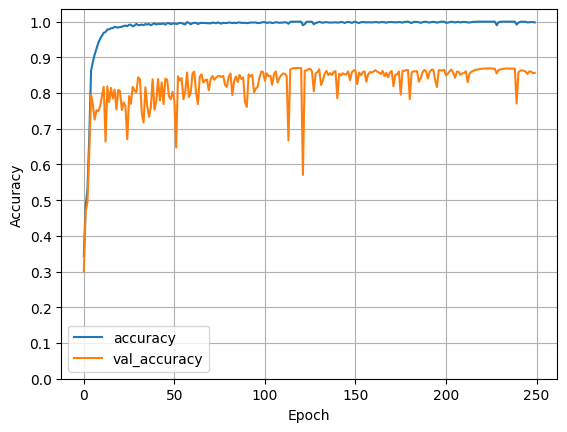

In [55]:
accuracies = model_train_info.history["accuracy"]
val_accuracies = model_train_info.history["val_accuracy"]

plt.plot(list(range(epochs)), accuracies, label = "accuracy")
plt.plot(list(range(epochs)), val_accuracies, label = "val_accuracy")
plt.legend()
plt.grid()
plt.xticks(ticks = list(range(1, epochs + 1))) 
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(ticks=list(range(0, epochs + 1, 50)))
plt.yticks(ticks=list(np.arange(0, 1 + 0.1, 0.1)))
plt.show()

In [56]:
print(f"資料: {mfcc_matrix_list.shape}")
print(f"最高準確率: {max(val_accuracies)}")

資料: (66852, 13, 44)
最高準確率: 0.8701667785644531


In [57]:
model.save(f".\\cnn_layer1_with_fake_model.h5")